# Spectral similarity

Compare different techniques to measure how different 2 spectra are.
Using vibration data from motors, both healthy and falty

** Work in progress

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from functools import partial
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine,euclidean,correlation,minkowski
from sklearn.covariance import EmpiricalCovariance

import distance_utils as du

%matplotlib inline

In [2]:
files = [
    'MFPT Fault Data Sets/1 - Three Baseline Conditions/baseline_1.mat',
    'MFPT Fault Data Sets/1 - Three Baseline Conditions/baseline_2.mat',
    'MFPT Fault Data Sets/1 - Three Baseline Conditions/baseline_3.mat',
    'MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/OuterRaceFault_1.mat',
    'MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/OuterRaceFault_2.mat',
    'MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/OuterRaceFault_3.mat',
    'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_1.mat',
    'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_2.mat',
    'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_3.mat',
    'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_4.mat',
    'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_5.mat',
    'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_6.mat',
#     'MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_7.mat'
]

In [3]:
data_dict = du.load_data(files)

#### Overview on the spectrum for each subset

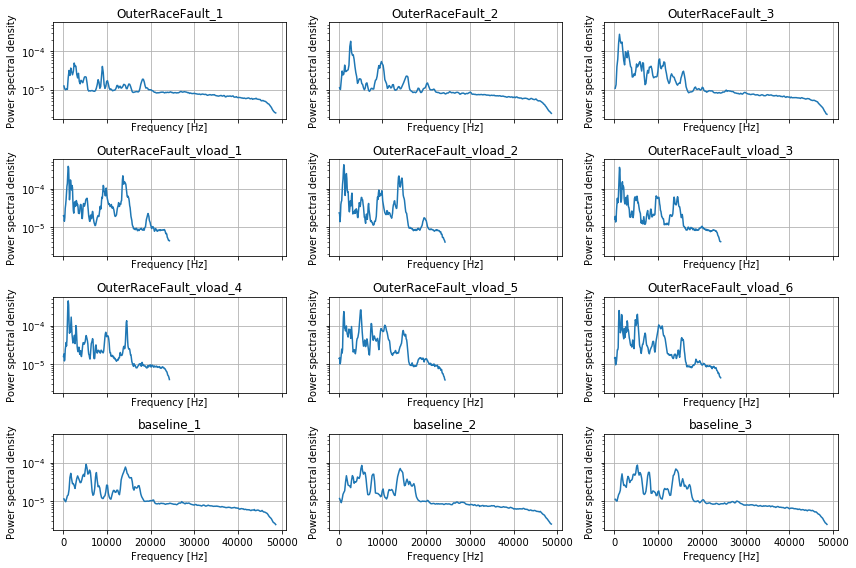

In [4]:
fig,axes = plt.subplots(len(data_dict)//3,3,figsize=(12,len(data_dict)//3*2),sharey=True,sharex=True)

for (key,value), ax in zip(sorted(data_dict.items()),axes.flatten()):
    freq, spectrum = signal.welch(value['gs'][:,0], fs=value['sr'], nperseg=500)
    ax.semilogy(freq[1:-1],spectrum[1:-1])
    ax.set_title(key)
    ax.grid()
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power spectral density')
fig.tight_layout()

#### Calculate and store spectra for each subset

In [5]:
du.init_data_dicts(data_dict,n_splits=1,inplace=True);

In [6]:
def compute_distances(func, data_dict, apply_before=lambda x:x):
    all_segments_list = du.get_segments_list(data_dict)
    distances = []
    all_segments_iter = itertools.combinations(all_segments_list,2)
    for (key1,split1),(key2,split2) in all_segments_iter:
        vec1 = data_dict[key1]['segment_fft'][split1]
        vec2 = data_dict[key2]['segment_fft'][split2]
        vec1 = apply_before(vec1)
        vec2 = apply_before(vec2)
        dist = func(vec1,vec2)
        comb_key1 = (key1,split1)
        comb_key2 = (key2,split2)
        distances.append((key1,split1,key2,split2,dist))
    return distances

def init_covariance(data_dict, n_splits=6):
    data_dict_tmp = du.init_data_dicts(data_dict,n_splits=n_splits,inplace=False)
    for k,v in data_dict_tmp.items():
        spectra = np.vstack(np.array(list(data_dict_tmp[k]['segment_fft'].values())))
        min_cov = EmpiricalCovariance()
        min_cov.fit(spectra)
        data_dict[k]['cov'] = min_cov

def compute_mahalanobis_distances(data_dict):
    init_covariance(data_dict, n_splits=6)
    all_segments_list = du.get_segments_list(data_dict)
    distances = []
    all_segments_iter = itertools.combinations(all_segments_list,2)
    for (key1,split1),(key2,split2) in all_segments_iter:
        vec2 = data_dict[key2]['segment_fft'][split2]
        min_cov = data_dict[key1]['cov']
        dist = min_cov.mahalanobis(vec2[None,:])[0]
        comb_key1 = (key1,split1)
        comb_key2 = (key2,split2)
        distances.append((key1,split1,key2,split2,dist))
    return distances

In [7]:
def max_diff(a,b):
    abs_diff = abs(a-b)
    return max(abs_diff)

def mse(a,b):
    """Mean squared error"""
    return np.mean((a-b)**2)

def scc(a,b):
    """Squared correlation coefficient"""
    return correlation(a,b)**2

def dcc(a,b):
    """First difference correlation coefficient"""
    da = np.diff(a)
    db = np.diff(b)
    return correlation(da,db)

def dscc(a,b):
    """First difference squared correlation coefficient"""
    return dcc(a,b)**2

def sec(a,b):
    """Squared Euclidean cosine"""
    return (sum(a*b)**2)/(sum(a**2)*sum(b**2))

### Pointwise similarity criteria

In [36]:
distance_functions = {
    "euclidean": partial(compute_distances,euclidean),
    "cosine": partial(compute_distances,cosine),
    "correlation": partial(compute_distances,correlation),
    "mahalanobis": compute_mahalanobis_distances,
    "max_diff": partial(compute_distances,max_diff),
    "mse": partial(compute_distances,mse),
    "scc": partial(compute_distances,scc),
    "dcc": partial(compute_distances,dcc),
    "dscc": partial(compute_distances,dscc),
    "sec" : partial(compute_distances,sec),
    "minkowski": partial(compute_distances,minkowski),
}

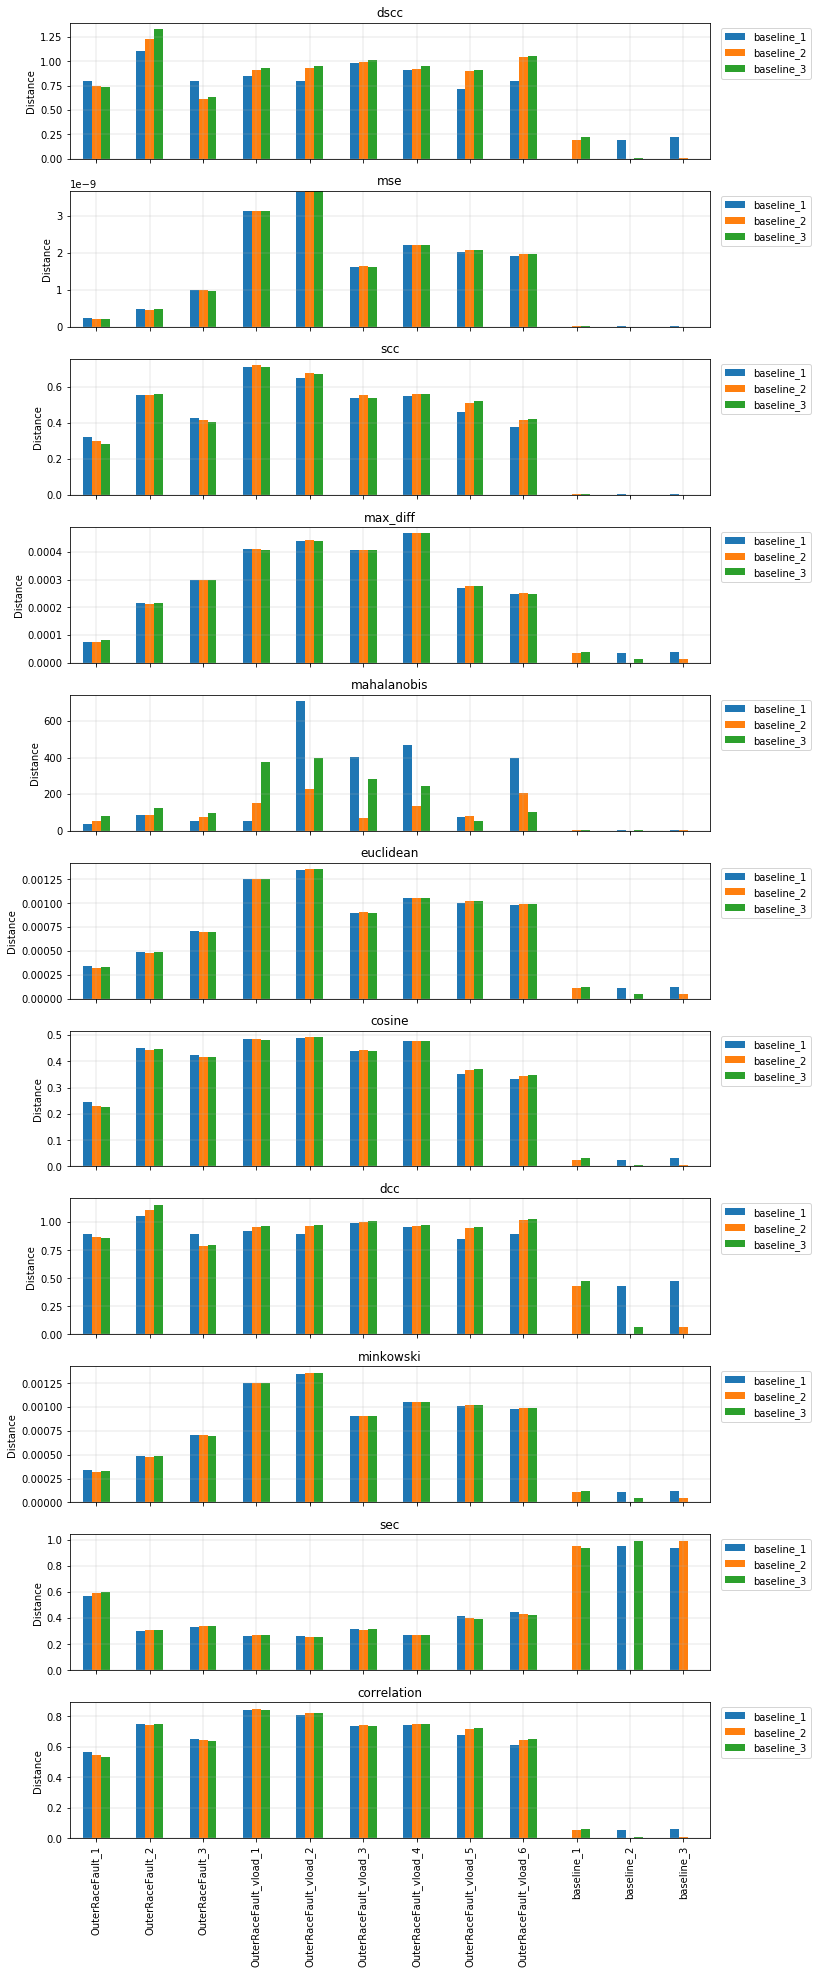

In [39]:
fig,ax = plt.subplots(len(distance_functions),1,figsize=(10,len(distance_functions)*2.5),sharex=True)
for (dist_name, dist_fcn), ax_ in zip(distance_functions.items(),ax.flatten()):
    distances = dist_fcn(data_dict)
    df_mean = du.plot_distances_bar(['baseline_1','baseline_2','baseline_3'],distances,ax=ax_)
    ax_.set_title(dist_name)
fig.tight_layout(pad=1.0)